In [1]:
import numpy as np
from scipy import optimize
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm

from tensorboardX import SummaryWriter
import torchvision.utils as vutils

from torch.utils.data import DataLoader
from torch.utils.data import Dataset

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from sklearn.decomposition import PCA

In [2]:
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 6
plt.rcParams['xtick.labelsize'] = 24
plt.rcParams['ytick.labelsize'] = 24
plt.rcParams['legend.fontsize'] = 12
plt.rcParams['axes.titlesize']=36
plt.rcParams['axes.labelsize']=24
plt.rcParams['figure.figsize'] = (24.0, 12.0)
plt.rcParams['font.size'] = 40

In [3]:
def RandomFunction(x):
    n = 10
    N = np.arange(1, n + 1, 1)
    A = np.random.randn(n)
    B = np.random.randn(n)
    A0 = np.random.randn(1)
    
    y = 0.5*np.ones_like(x)*A0
    
    for n, a, b in zip(N, A, B):
        y += a*np.sin(n*x) + b*np.cos(n*x)
    
    return y

def GenerateImpulses(n = 20, T = 2, phi = 0, k = 2, function = np.sin):
    
    t = int(T)//2
    
    x = np.linspace(start = 0, stop = T*np.pi, num = n)
    
    List_y = []
    
    for i in range(k):
        List_y.append(np.random.randn(1)*function(x + phi))
    
    y = np.array(List_y[0])
    
    y2 = List_y[np.random.randint(0, k)]
    
    for i in range(1, t):
        if np.random.rand() < 0.25:
            y2 = List_y[np.random.randint(0, k)]
        
        ind = np.where(x <= 2*(i + 1)*np.pi)
        ind = np.where(x[ind] > 2*i*np.pi)
        y[ind] = y2[ind]
        
    return y
    

def GeneratorOfTimeSeries(n = 100, m = 16384, noise = False):
    T1 = []
    T2 = []
    T3 = []
    for _ in range(m):
        numPi = 80 + np.random.randint(0, 20)
#         numPi = 100
        phi = np.random.rand()*2*np.pi*0
        function = np.sin
        if np.random.rand() < 4*0.5:
            function = RandomFunction
            
        series = GenerateImpulses(n = n, T = numPi, phi = phi, k = np.random.randint(2, 3), function=function)
        T1.append(series + 0.1*np.random.randn(n))
    T1 = np.asarray(T1)
    
    return np.reshape(T1, [T1.shape[0], T1.shape[1], 1])

  
class TimeSeries(Dataset):
    def __init__(self, X, Y, device = 'cpu'):
        super(TimeSeries, self).__init__()
        self.X = torch.FloatTensor(X).to(device)
        self.Y = torch.FloatTensor(Y).to(device)
        self.len = X.shape[0]

    def __len__(self):
        return self.len

    def __getitem__(self, index):
        return self.X[index], self.Y[index]

In [4]:
X_train = GeneratorOfTimeSeries(n = 5000, m = 128, noise = True)

In [5]:
X_test = GeneratorOfTimeSeries(n = 5000, m = 8)

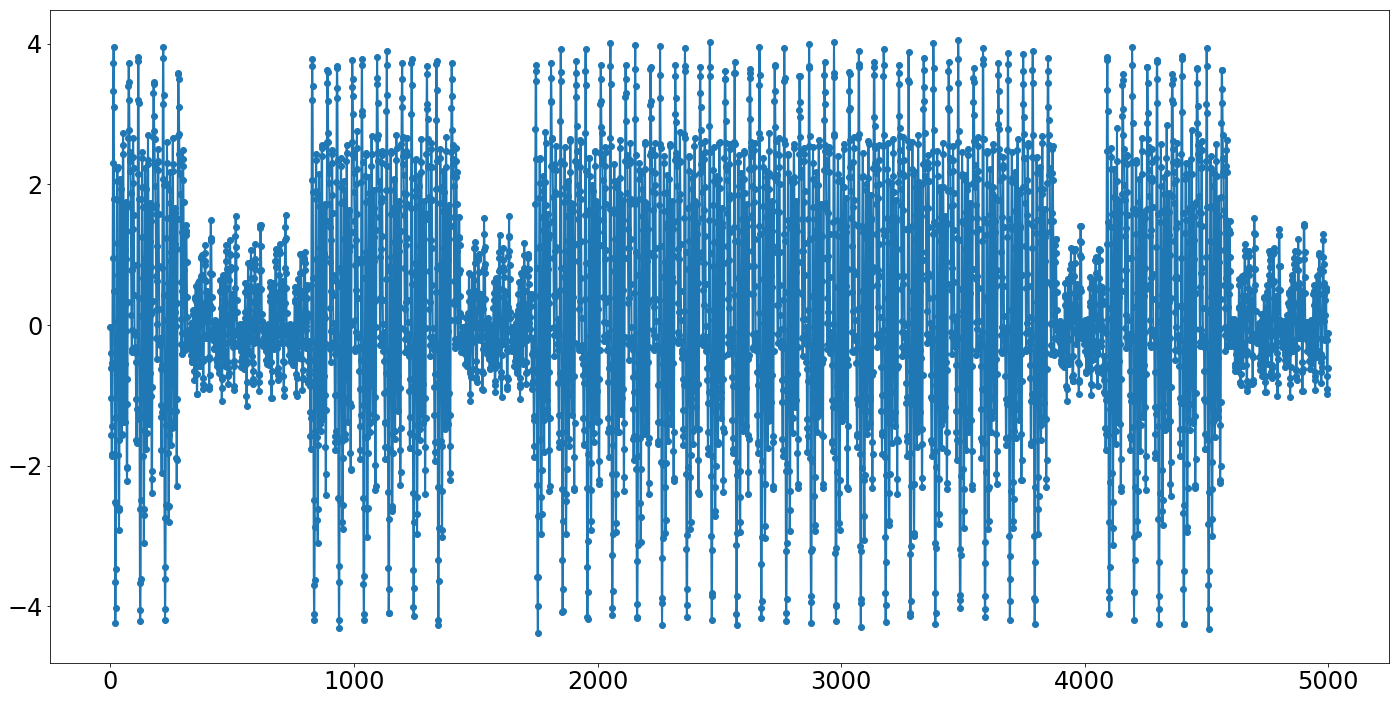

In [6]:
_ = plt.plot(X_test[0], '-o')

In [7]:
X_test.shape

(8, 5000, 1)

In [8]:
def return_h(input, i, l = 10):
    return np.sum(input[:, i:i+l, :], axis = -1)

def return_phase_track(input, l = 10):
    """
    input has a shape [batch_size, time_len, 1]
    """

    phase_track = np.zeros([input.shape[0], input.shape[1] - l, l])
    
    for i in range(0, input.shape[1] - l):
        phase_track[:, i, :] = return_h(input, i, l)
    
    return phase_track
    
    

In [9]:
ramp = lambda u: np.maximum( u, 0 )
step = lambda u: ( u > 0 ).astype(float)

def SegmentedLinearReg( X, Y, breakpoints ):
    nIterationMax = 200

    breakpoints = np.sort( np.array(breakpoints) )

    dt = np.min( np.diff(X) )
    ones = np.ones_like(X)

    for i in range( nIterationMax ):
        # Linear regression:  solve A*p = Y
        Rk = [ramp( X - xk ) for xk in breakpoints ]
        Sk = [step( X - xk ) for xk in breakpoints ]
        A = np.array([ ones, X ] + Rk + Sk )
        p =  np.linalg.lstsq(A.transpose(), Y, rcond=None)[0] 

        # Parameters identification:
        a, b = p[0:2]
        ck = p[ 2:2+len(breakpoints) ]
        dk = p[ 2+len(breakpoints): ]

        # Estimation of the next break-points:
        newBreakpoints = breakpoints - dk/ck 

        # Stop condition
        if np.max(np.abs(newBreakpoints - breakpoints)) < dt/5:
            break

        breakpoints = newBreakpoints
    else:
        print( 'maximum iteration reached' )

    # Compute the final segmented fit:
    Xsolution = np.insert( np.append( breakpoints, max(X) ), 0, min(X) )
    ones =  np.ones_like(Xsolution) 
    Rk = [ c*ramp( Xsolution - x0 ) for x0, c in zip(breakpoints, ck) ]

    Ysolution = a*ones + b*Xsolution + np.sum( Rk, axis=0 )
    return Xsolution, Ysolution, breakpoints

In [10]:
T = 100

In [11]:
res = return_phase_track(X_test, T)

In [12]:
res.shape

(8, 4900, 100)

In [13]:
List_of_point = []
List_of_x = []
List_of_s = []
List_of_u = []
List_of_v = []

for n in tqdm(range(T, res[0].shape[0], 1)):
    if n-T > 0:
        arr = res[0][n-T:n]
    else:
        arr = res[0][:n]
        
    u, s, v = np.linalg.svd(arr)
    x = np.array(np.arange(0, s.shape[0], 1), dtype=float)
    y = np.array(s[::-1])

#     initialBreakpoints = [5]
#     X, Y, point = SegmentedLinearReg(x, y, initialBreakpoints)
    
#     List_of_point.append(y.shape[0] - int(point[0]))
    List_of_x.append(n)
    
    List_of_s.append(s)
    List_of_u.append(u)
    List_of_v.append(v)
    

In [14]:
List_of_s = np.array(List_of_s)
List_of_u = np.array(List_of_u)
List_of_v = np.array(List_of_v)
List_of_x = np.array(List_of_x)
# List_of_point = np.array(List_of_point)

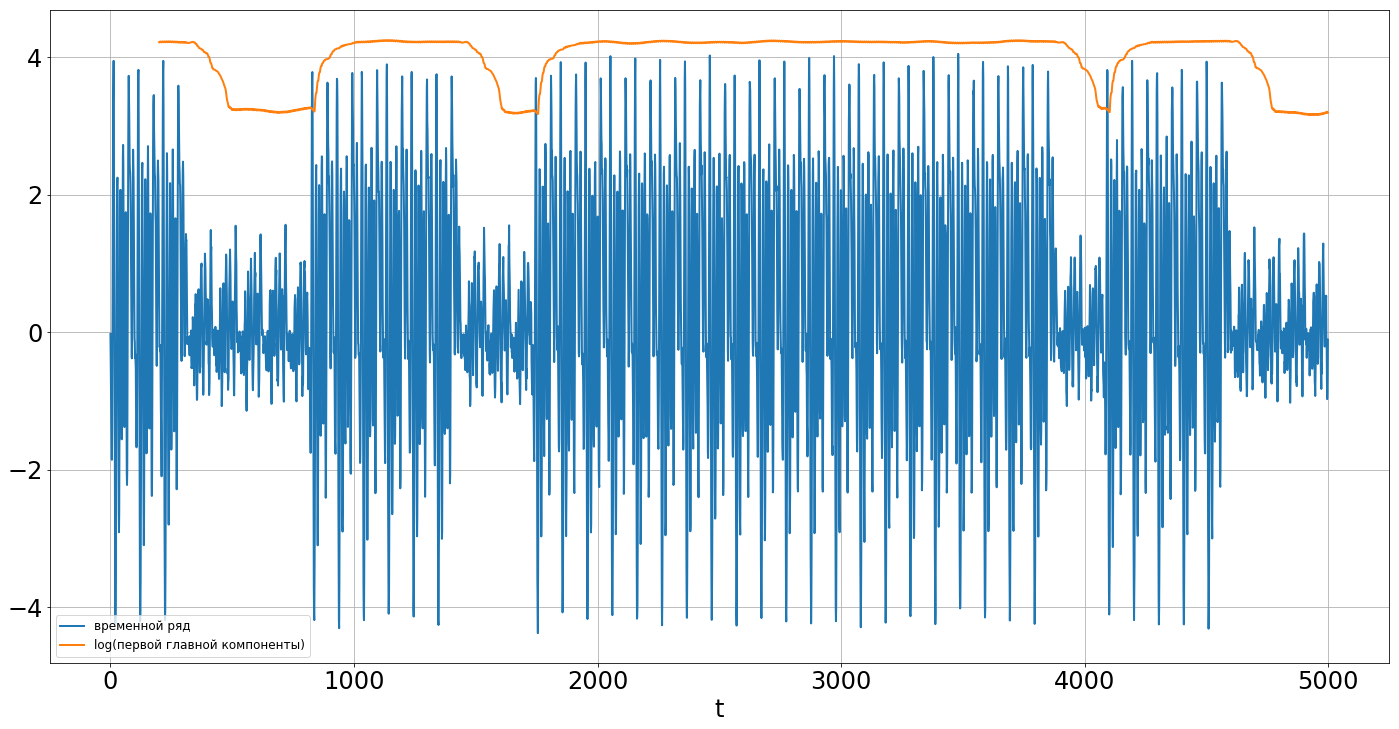

In [15]:
# plt.plot(List_of_x+T, List_of_point, '-', label = '# главных компонент')
plt.plot(X_test[0], '-', label = 'временной ряд')
plt.plot(List_of_x+T, np.log(List_of_s[:,0]), '-', label = 'log(первой главной компоненты)')

plt.grid()
plt.xlabel('t')
plt.legend(loc = 'best')
plt.show()

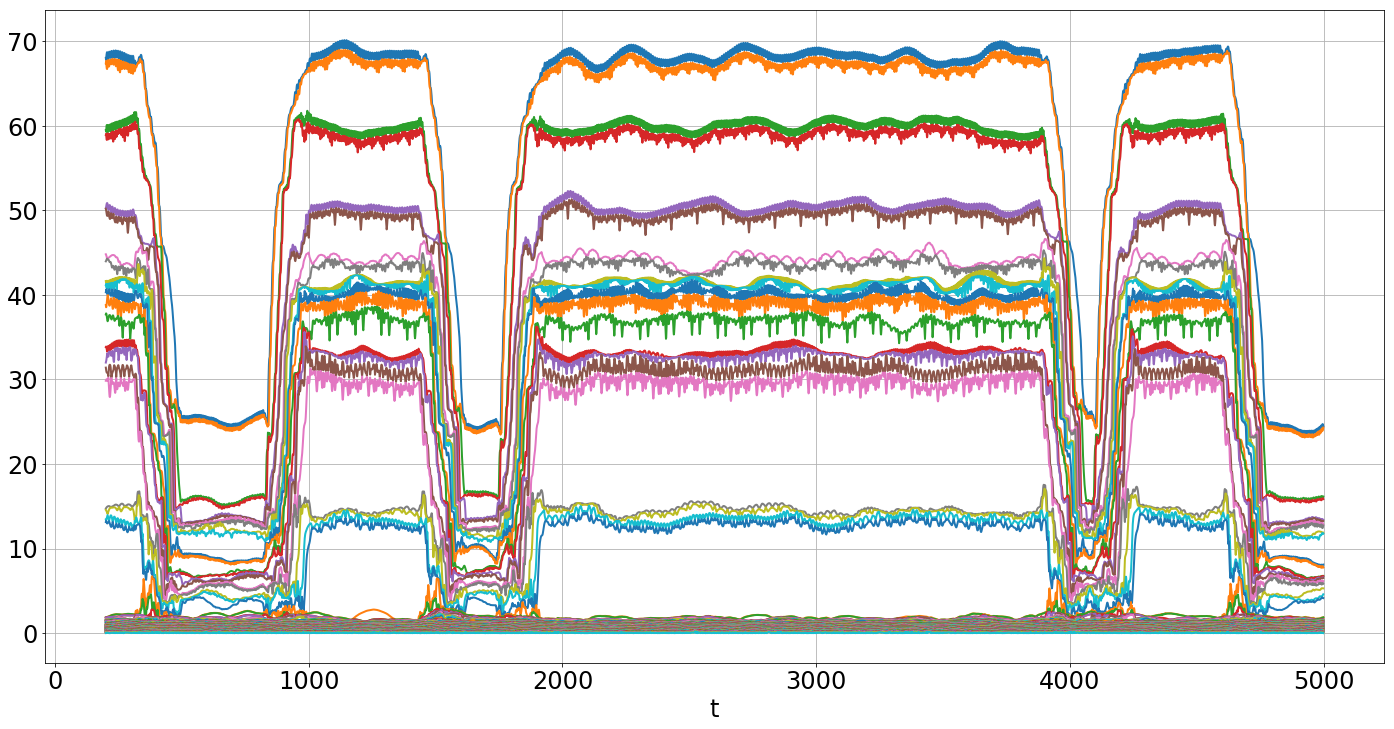

In [16]:
_ = plt.plot(List_of_x+T, List_of_s[:,:], '-')


plt.grid()
plt.xlabel('t')
plt.show()

In [17]:
List_of_s.shape

(4800, 100)

In [18]:
from sklearn.cluster import KMeans

In [19]:
model = KMeans(n_clusters=3)

In [20]:
model.fit(List_of_s)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [21]:
prediction = model.predict(List_of_s)

In [22]:
prediction.shape

(4800,)

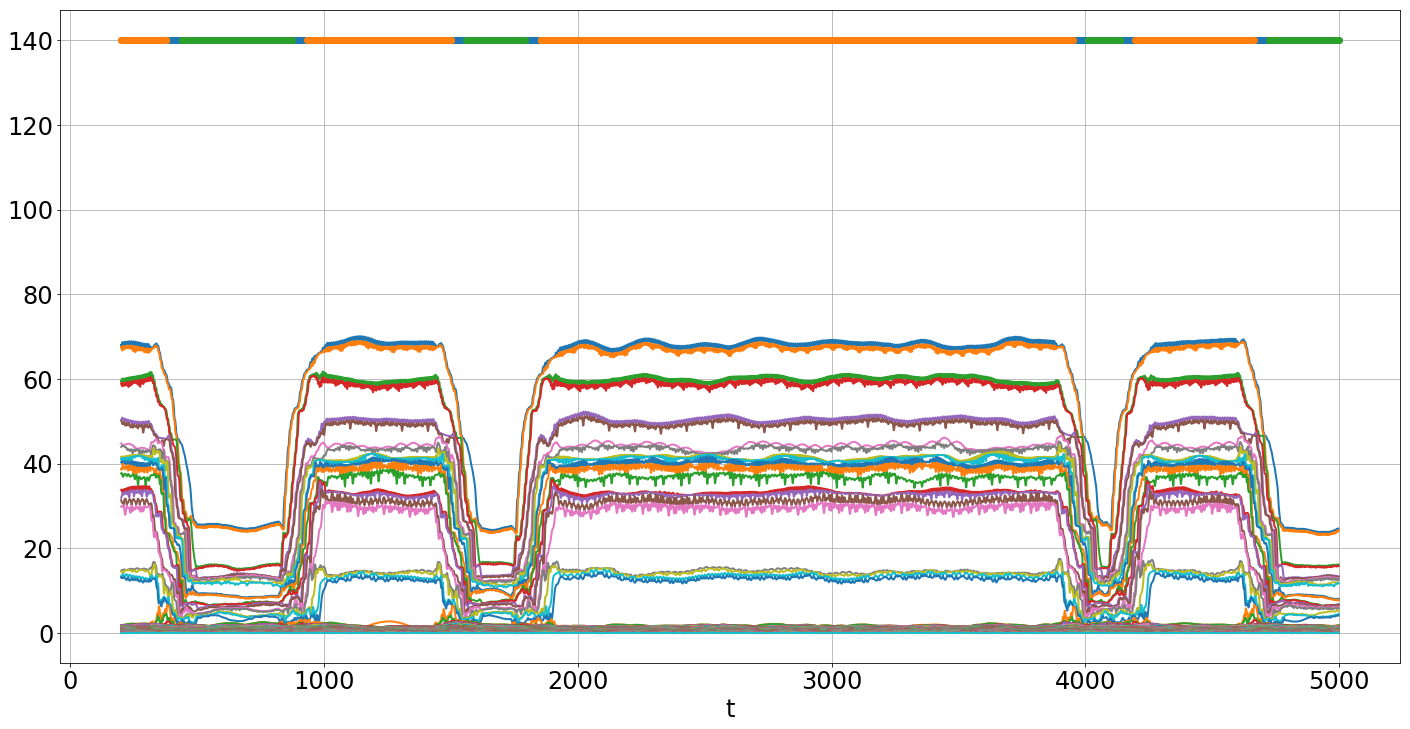

In [23]:
_ = plt.plot(List_of_x+T, List_of_s[:,:], '-')

line = np.ones_like(List_of_x)*140

ind = np.where(prediction == 0)
_ = plt.plot(List_of_x[ind]+T, line[ind], 'o')

ind = np.where(prediction == 1)
_ = plt.plot(List_of_x[ind]+T, line[ind], 'o')

ind = np.where(prediction == 2)
_ = plt.plot(List_of_x[ind]+T, line[ind], 'o')

plt.grid()
plt.xlabel('t')
plt.show()

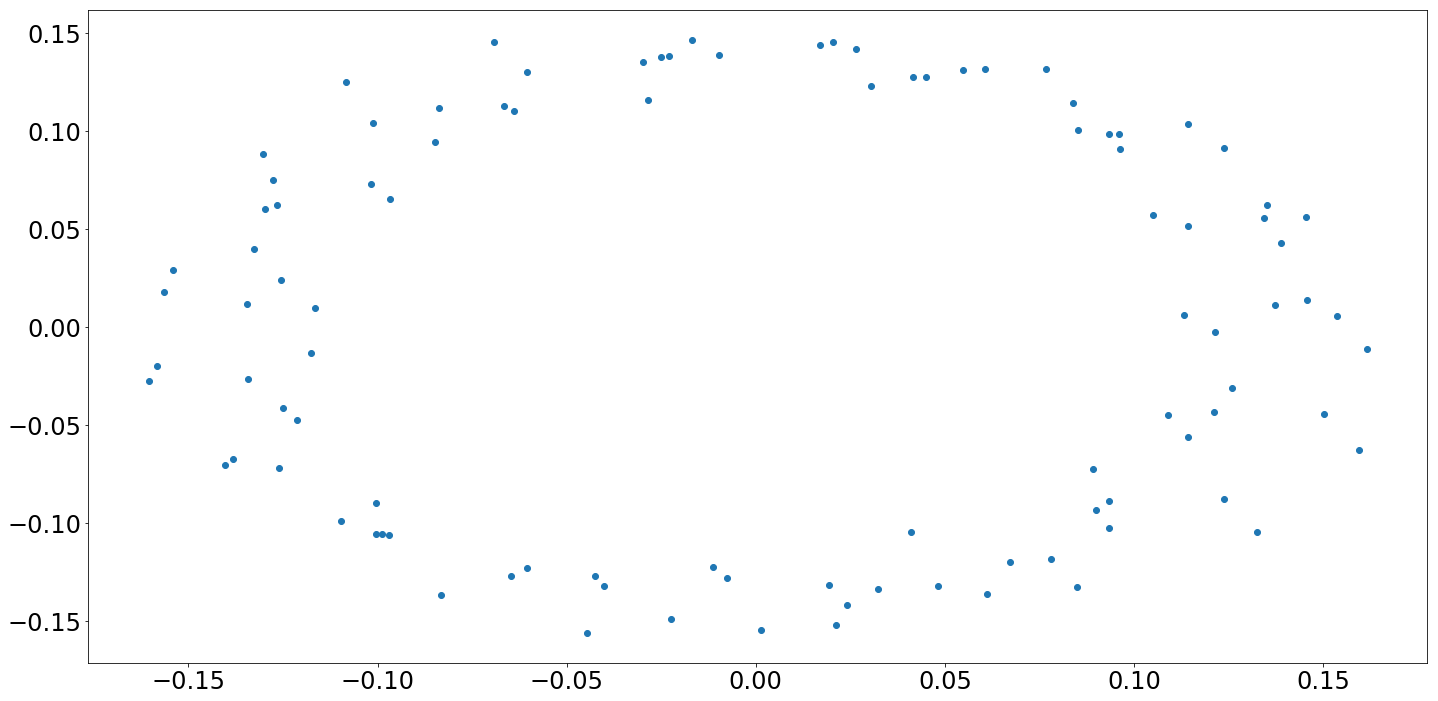

In [24]:
model_pca = PCA(n_components=2)
kkk= 2900
model_pca.fit(res[0][kkk:kkk+100])

component = model_pca.components_

_ = plt.plot(component[0, :], component[1, :], 'o')

In [25]:
model_pca = PCA(n_components=2)
result_pca = model_pca.fit_transform(res[0])

In [26]:
result_pca.shape

(4900, 2)

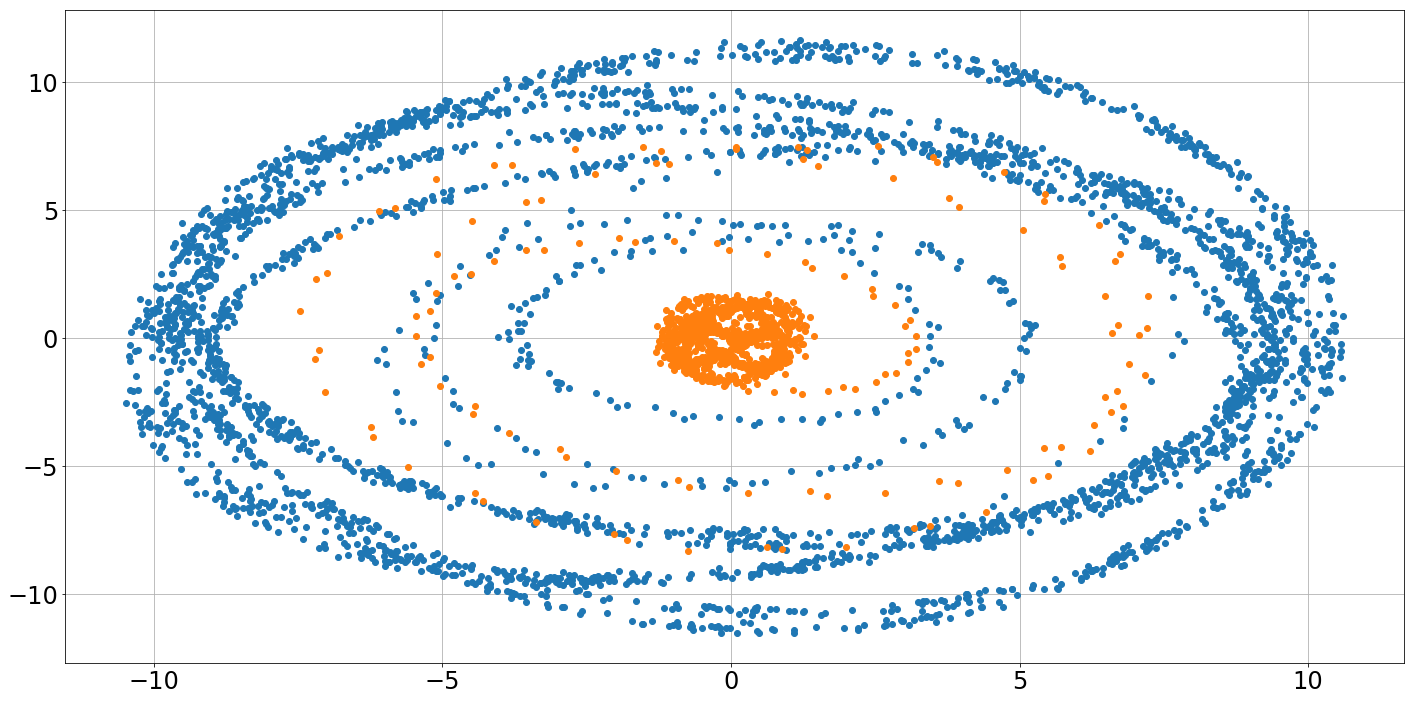

In [28]:
# ind = np.where(prediction == 0)
# _ = plt.plot(result_pca[T:, 0][ind], result_pca[T:, 1][ind], 'o')

ind = np.where(prediction == 1)
_ = plt.plot(result_pca[T:, 0][ind], result_pca[T:, 1][ind], 'o')

ind = np.where(prediction == 2)
_ = plt.plot(result_pca[T:, 0][ind], result_pca[T:, 1][ind], 'o')

plt.grid()
plt.show()